In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from data import load_database_train
from preprocessing import InterpolateRawData
from train import grid_search
from sklearn.model_selection import cross_val_score
from cross_validation import cv_folds_author

%matplotlib inline

In [2]:
database_train = load_database_train()

# Modelo Base

## Analisando quantidade de amostragem na interpolação dos dados 

In [ ]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]}
grid_search(pipe, parameters, database_train.X, database_train.y, n_jobs=6)

Segundo modelo base de **Regressão Logistica**, o num_samples = 80 trouxe bons resultados, e maiores amostragens não trouxeram mudanças significativas. Nosso método grid_search já faz o Kfold considerando como divisaão de dados os autores (**cv_folds_author**)

Olhando os scores abaixo, percebemos como houve muita variação entre os folds, visto que cada fold é um autor com celular diferente que não tem no modelo.

In [ ]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData(num_samples=80)),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, database_train.X, database_train.y, cv=cv_folds_author(database_train.X)))

Se não usassemos este método, e os dados fossem misturado, o resultado do modelo seria muito enviesado como abaixo, onde manteve uma boa acurácia acima dos 84% em todos os folds

In [ ]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData(num_samples=80)),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, database_train.X, database_train.y, cv=5))

# Redes Neurais

In [ ]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]}
grid_search(pipe, parameters, database_train.X, database_train.y, n_jobs=6)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  28 out of  35 | elapsed:    8.6s remaining:    2.2s
[Parallel(n_jobs=6)]: Done  32 out of  35 | elapsed:   12.1s remaining:    1.1s
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed:   14.1s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'interpolate__num_samples': 5},0.94,0.03,0.65,0.16
1,{'interpolate__num_samples': 10},1.00,0.00,0.65,0.12
2,{'interpolate__num_samples': 20},1.00,0.00,0.67,0.14
3,{'interpolate__num_samples': 40},1.00,0.00,0.70,0.15
4,{'interpolate__num_samples': 80},1.00,0.00,0.70,0.15
5,{'interpolate__num_samples': 120},1.00,0.00,0.70,0.15
6,{'interpolate__num_samples': 240},1.00,0.00,0.70,0.15


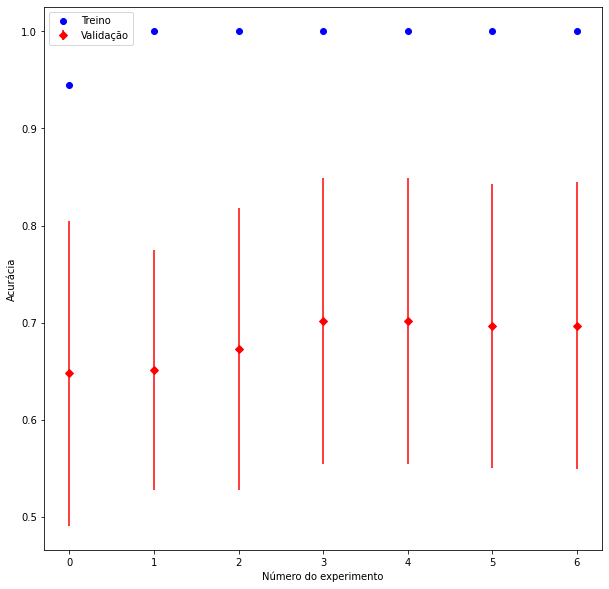

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
4,{'interpolate__num_samples': 80},1.00,0.00,0.70,0.15


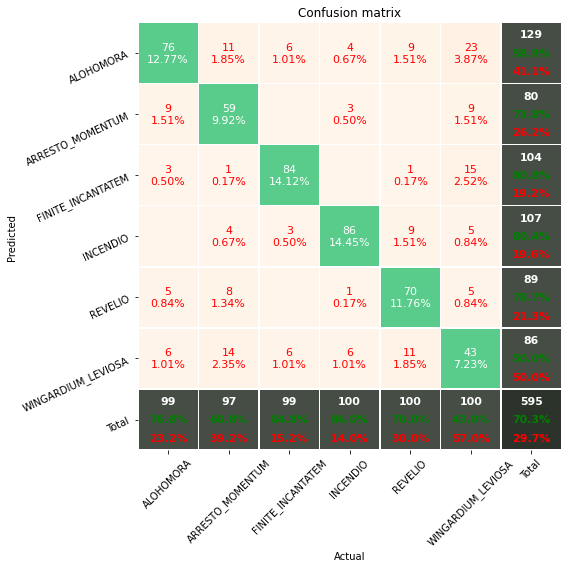

Pipeline(steps=[('interpolate', InterpolateRawData(num_samples=80)),
                ('logistic',
                 LogisticRegression(max_iter=100000, random_state=0))])

In [5]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]}
grid_search(pipe, parameters, database_train.X, database_train.y, n_jobs=6)

Segundo modelo base de **Regressão Logistica**, o num_samples = 80 trouxe bons resultados, e maiores amostragens não trouxeram mudanças significativas. Nosso método grid_search já faz o Kfold considerando como divisaão de dados os autores (**cv_folds_author**)

Olhando os scores abaixo, percebemos como houve muita variação entre os folds, visto que cada fold é um autor com celular diferente que não tem no modelo.

In [3]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData(num_samples=80)),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, database_train.X, database_train.y, cv=cv_folds_author(database_train.X)))

[0.79166667 0.47008547 0.875      0.77966102 0.58333333]


Se não usassemos este método, e os dados fossem misturado, o resultado do modelo seria muito enviesado como abaixo, onde manteve uma boa acurácia acima dos 84% em todos os folds

In [4]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData(num_samples=80)),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, database_train.X, database_train.y, cv=5))

[0.8907563  0.90756303 0.84033613 0.89915966 0.85714286]


# Redes Neurais

In [ ]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]}
grid_search(pipe, parameters, database_train.X, database_train.y, n_jobs=6)